# Import Necessary Libraries and modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!python -V

Python 3.7.11


In [5]:
import numpy as np
import tensorflow.keras
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,BatchNormalization,Flatten,Activation
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import seaborn as sns

# Directories of the datasets


In [6]:
train_directory='/content/drive/MyDrive/bird/train'
val_directory='/content/drive/MyDrive/bird/valid'
test_directory='/content/drive/MyDrive/bird/test'

# Rescaling the Images

In [7]:
train_datagen=ImageDataGenerator(rescale=1/255)
val_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

# Using the flow from directory function for reading the images

In [8]:
train_generator=train_datagen.flow_from_directory(train_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                  batch_size=256,
                                                 class_mode='sparse')
val_generator=val_datagen.flow_from_directory(val_directory,
                                                 target_size=(224,224),
                                                 batch_size=256,
                                                 color_mode='rgb',
                                                 class_mode='sparse')
test_generator=test_datagen.flow_from_directory(test_directory,
                                                batch_size=256,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='sparse')

Found 1749 images belonging to 13 classes.
Found 65 images belonging to 13 classes.
Found 65 images belonging to 13 classes.


# The Dictionary

In [9]:
num_classes=(len(train_generator.class_indices))

In [10]:
train_generator.class_indices

{'BALD EAGLE': 0,
 'BLACK SWAN': 1,
 'BLACK VULTURE': 2,
 'BLACK-THROATED SPARROW': 3,
 'CROW': 4,
 'EMU': 5,
 'MALACHITE KINGFISHER': 6,
 'MALLARD DUCK': 7,
 'MOURNING DOVE': 8,
 'MYNA': 9,
 'PEACOCK': 10,
 'SCARLET MACAW': 11,
 'WILD TURKEY': 12}

# Understanding the Data

In [11]:
breeds=list(train_generator.class_indices.keys())

In [12]:
x=list(train_generator.classes)

In [13]:
label=[]
for i in range (0,225):
    label.append(x.count(i))


# Using Resnet50v2 with imagenet weights

In [14]:
from tensorflow.keras.applications import ResNet50V2

In [15]:
convlayer=ResNet50V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in convlayer.layers:
    layer.trainable=False

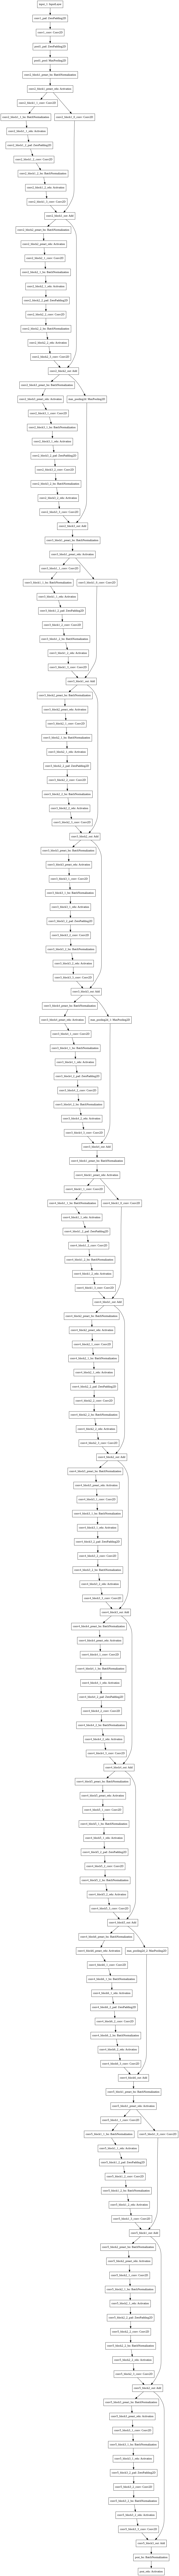

In [16]:
plot_model(convlayer)

# Adding the layer to the Dense Layers

In [17]:
model=Sequential()
model.add(convlayer)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax',kernel_initializer='glorot_uniform'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

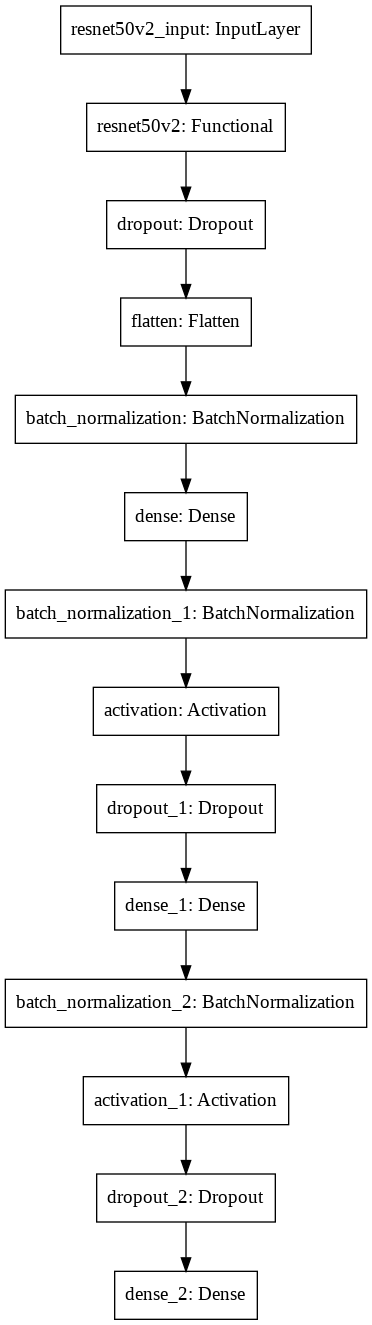

In [18]:
plot_model(model)

# Use a small learning rate for better accuracy

In [19]:
from tensorflow.keras import optimizers
optimizer=optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
history=model.fit(train_generator,epochs=7,validation_data=val_generator)

Epoch 1/7
7/7 [==============================] - 232s 32s/step - loss: 1.3351 - accuracy: 0.6095 - val_loss: 0.0809 - val_accuracy: 0.9692
Epoch 2/7
7/7 [==============================] - 229s 33s/step - loss: 0.1972 - accuracy: 0.9691 - val_loss: 0.0410 - val_accuracy: 0.9692
Epoch 3/7
7/7 [==============================] - 231s 33s/step - loss: 0.1075 - accuracy: 0.9834 - val_loss: 0.0367 - val_accuracy: 0.9846
Epoch 4/7
7/7 [==============================] - 226s 33s/step - loss: 0.0497 - accuracy: 0.9983 - val_loss: 0.0396 - val_accuracy: 0.9846
Epoch 5/7
7/7 [==============================] - 227s 32s/step - loss: 0.0311 - accuracy: 0.9977 - val_loss: 0.0338 - val_accuracy: 0.9846
Epoch 6/7
7/7 [==============================] - 229s 33s/step - loss: 0.0253 - accuracy: 0.9977 - val_loss: 0.0247 - val_accuracy: 0.9846
Epoch 7/7
7/7 [==============================] - 226s 32s/step - loss: 0.0150 - accuracy: 0.9994 - val_loss: 0.0180 - val_accuracy: 0.9846


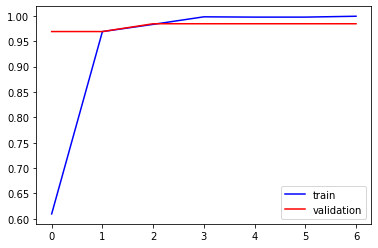

In [21]:
plt.plot(history.history['accuracy'],c='b',label='train')
plt.plot(history.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

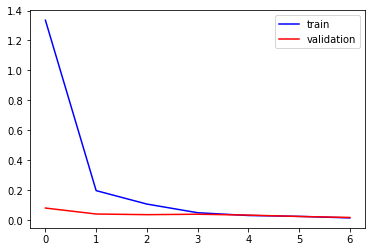

In [22]:
plt.plot(history.history['loss'],c='b',label='train')
plt.plot(history.history['val_loss'],c='r',label='validation')
plt.legend(loc='upper right')
plt.show()

# Check your Accuracy on the Test set

In [23]:
model.evaluate(test_generator)

1/1 [==============================] - 7s 7s/step - loss: 0.0264 - accuracy: 0.9846


[0.02635360322892666, 0.9846153855323792]

# Check for Your Own Image

In [24]:
def predict(dir):
    img=image.load_img(dir,target_size=(224,224))
    img1=image.img_to_array(img)
    img1=img1/255
    img1=np.expand_dims(img1,[0])
    plt.imshow(img)
    pred=int((model.predict_classes(img1)))
    for key,values in train_generator.class_indices.items():
        if pred==values:
            print("The predicted image of the bird is: "+str(key)+" with a probability of "+str(round(np.max(model.predict_proba(img1))*100,2))+"%")
    
    

# Example1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


The predicted image of the bird is: BALD EAGLE with a probability of 100.0%


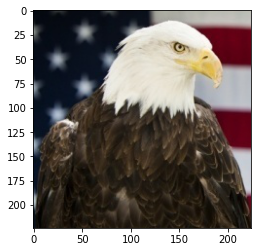

In [25]:
predict('/content/drive/MyDrive/bird/valid/BALD EAGLE/1.jpg')

# Example2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


The predicted image of the bird is: BLACK VULTURE with a probability of 62.13%


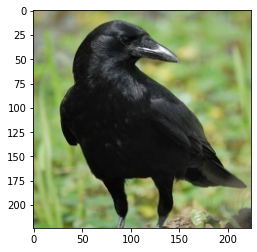

In [26]:
predict('/content/drive/MyDrive/bird/valid/CROW/3.jpg')